In [1]:
source("shared.R")

Loading required package: coda
Linked to JAGS 4.1.0
Loaded modules: basemod,bugs


In [3]:
data("PlantGrowth")
head(PlantGrowth)

weight,group
4.17,ctrl
5.58,ctrl
5.18,ctrl
6.11,ctrl
4.50,ctrl
4.61,ctrl


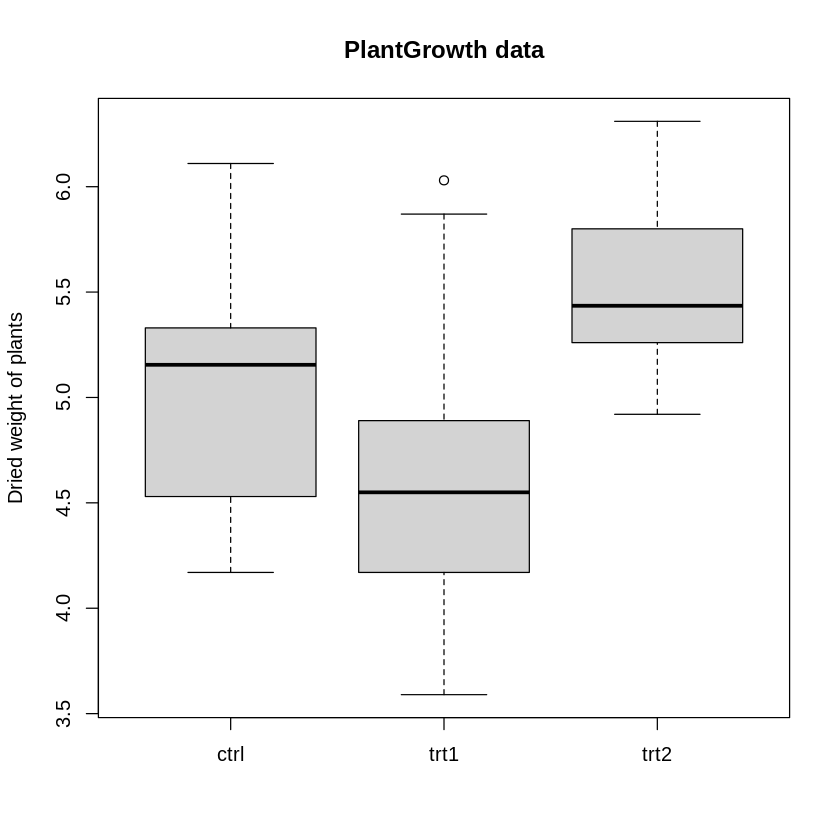

In [4]:
boxplot(weight ~ group, data = PlantGrowth, main = "PlantGrowth data",
        ylab = "Dried weight of plants", col = "lightgray",
        notch = FALSE, varwidth = TRUE)

In [5]:
#?effects
#?anova
anova(lm(weight ~ group, data = PlantGrowth))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
group,2,3.76634,1.8831700,4.846088,0.01590996
Residuals,27,10.49209,0.3885959,NA,NA


In [6]:
lmod = lm(weight ~ group, data=PlantGrowth)
summary(lmod)


Call:
lm(formula = weight ~ group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.0320     0.1971  25.527   <2e-16 ***
grouptrt1    -0.3710     0.2788  -1.331   0.1944    
grouptrt2     0.4940     0.2788   1.772   0.0877 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.2641,	Adjusted R-squared:  0.2096 
F-statistic: 4.846 on 2 and 27 DF,  p-value: 0.01591


In [14]:
str_model = "model {
    for (i in 1:length(y)) { 
        y[i] ~ dnorm(mu[grp[i]], prec)
    }
    
    for (j in 1:3) {
        mu[j] ~ dnorm(0, 1./1.e6)
    }

    # here 5 is the sample size, 1 is the variance
    prec ~ dgamma(5/2.0, 5*1/2.0) 

    sig = sqrt(1./prec)    
} "

dat = c()
var_names = c("mu", "sig")
inits = function() {
    inits = list("mu" = rnorm(3, 0, 100), "prec" = rgamma(1, 1., 1.))
}
data = list(y=PlantGrowth$weight, grp=as.numeric(PlantGrowth$group))

In [15]:
mod = jags_model_compile(str_model_ = str_model, data_ = data, inits_ = inits, n_chains_ = 3, burnout = 1e5)
sim = jags_model_sample(mod_ = mod, n_iter_ = 1e4, var_names_ = var_names)
mod_diag = jags_model_diag(samples_ = sim$samples)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 4
   Total graph size: 85

Initializing model



In [9]:
pm_params = colMeans(sim$samples_cmb)
summary(sim$samples)


Iterations = 100001:110000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean      SD  Naive SE Time-series SE
mu[1] 5.0338 0.22801 0.0013164      0.0013239
mu[2] 4.6613 0.22539 0.0013013      0.0013013
mu[3] 5.5261 0.22766 0.0013144      0.0013001
sig   0.7126 0.09207 0.0005316      0.0005814

2. Quantiles for each variable:

        2.5%    25%    50%    75%  97.5%
mu[1] 4.5847 4.8843 5.0335 5.1835 5.4853
mu[2] 4.2197 4.5104 4.6606 4.8118 5.1033
mu[3] 5.0785 5.3763 5.5261 5.6760 5.9737
sig   0.5594 0.6472 0.7037 0.7675 0.9196


In [10]:
HPDinterval(sim$samples_cmb[,3] - sim$samples_cmb[,1])

,lower,upper
var1,-0.1611049,1.105247


In [53]:
HPDinterval(sim$samples_cmb, prob = 0.9)

,lower,upper
mu[1],4.651401,5.3884966
mu[2],4.283159,5.0190971
mu[3],5.154535,5.9052546
sig,0.566241,0.8582024


In [11]:
mod_cm = lm(weight ~ -1 + group, data=PlantGrowth)
summary(mod_cm)


Call:
lm(formula = weight ~ -1 + group, data = PlantGrowth)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.0710 -0.4180 -0.0060  0.2627  1.3690 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
groupctrl   5.0320     0.1971   25.53   <2e-16 ***
grouptrt1   4.6610     0.1971   23.64   <2e-16 ***
grouptrt2   5.5260     0.1971   28.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6234 on 27 degrees of freedom
Multiple R-squared:  0.9867,	Adjusted R-squared:  0.9852 
F-statistic: 665.5 on 3 and 27 DF,  p-value: < 2.2e-16


In [19]:
HPDinterval(sim$samples_cmb, prob = 0.9)

,lower,upper
mu[1],4.6164637,5.4623890
mu[2],4.1774673,5.1480443
mu[3],5.1350603,5.9123839
sig[1],0.5410625,1.0402909
sig[2],0.6331949,1.2095278
sig[3],0.5084932,0.9672212


## Fitting model with varied variance for each group

In [12]:
model_varied_var = "model {
    for (i in 1:length(y)) { 
        y[i] ~ dnorm(mu[grp[i]], prec[grp[i]])
    }    
    for (j in 1:3) {
        mu[j] ~ dnorm(0, 1./1.e6)
        prec[j] ~ dgamma(5/2.0, 5*1/2.0) 
        sig[j] = sqrt(1./prec[j])
    }    
} "


var_names = c("mu", "sig")
inits = function() {
    inits = list("mu" = rnorm(3, 0, 100), "prec" = rgamma(3, 1., 1.))
}
data = list(y=PlantGrowth$weight, grp=as.numeric(PlantGrowth$group))

In [13]:
jmod_varied_var = jags_model_compile(model_varied_var, data, inits)
sim2 = jags_model_sample(jmod_varied_var, n_iter_ = 1e4, var_names_ = var_names)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 6
   Total graph size: 105

Initializing model



In [18]:
dic.samples(mod, n.iter=1e5) - dic.samples(jmod_varied_var, n.iter=1e5)

Difference: -3.861668
Sample standard error: 1.637241

In [22]:
d1 = dic.samples(model = jmod_varied_var, n.iter = 1e4)

In [23]:
dics = list("m1" = dic.samples(model = jmod_varied_var, n.iter = 1e4),  "m2" = dic.samples(model = mod, n.iter = 1e4))

In [36]:
a = dic.samples(model = jmod_varied_var, n.iter = 1e4)

In [18]:
summary(sim$samples_cmb)


Iterations = 1:30000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean     SD  Naive SE Time-series SE
mu[1]  5.0324 0.2574 0.0014862      0.0015007
mu[2]  4.6586 0.2980 0.0017203      0.0017203
mu[3]  5.5257 0.2385 0.0013772      0.0013772
sig[1] 0.8034 0.1651 0.0009534      0.0010126
sig[2] 0.9240 0.1915 0.0011054      0.0011959
sig[3] 0.7361 0.1520 0.0008775      0.0009492

2. Quantiles for each variable:

         2.5%    25%    50%    75% 97.5%
mu[1]  4.5178 4.8667 5.0325 5.1974 5.546
mu[2]  4.0636 4.4684 4.6616 4.8498 5.253
mu[3]  5.0536 5.3736 5.5249 5.6791 5.998
sig[1] 0.5548 0.6869 0.7793 0.8913 1.192
sig[2] 0.6370 0.7897 0.8940 1.0264 1.384
sig[3] 0.5087 0.6289 0.7128 0.8171 1.100


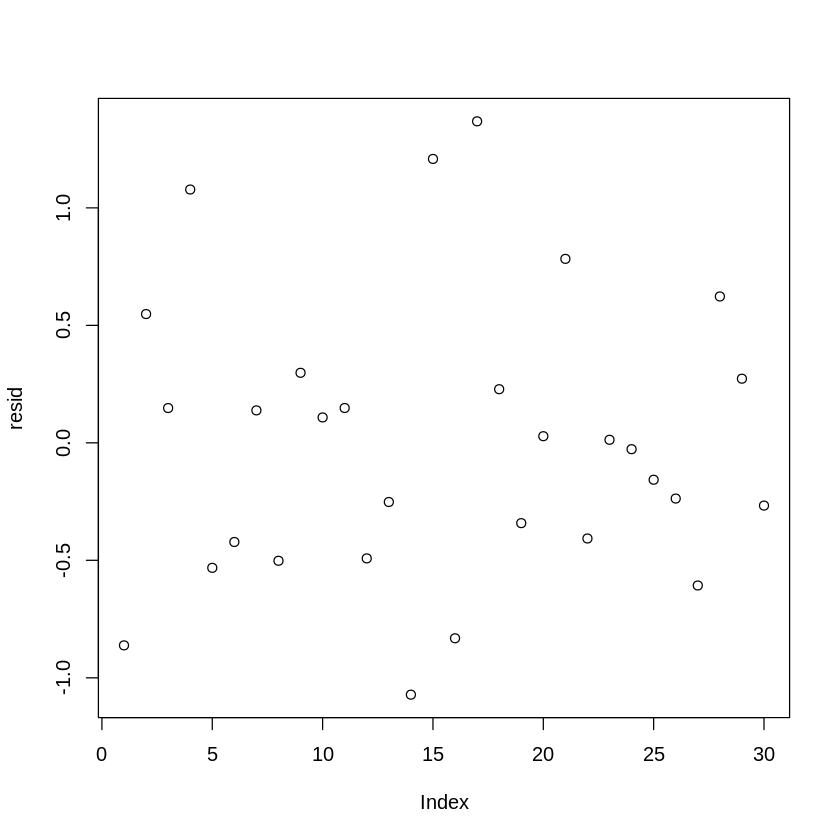

In [73]:
y_hat = pm_params[1:3][data$grp]
resid = data$y - y_hat
plot(resid)

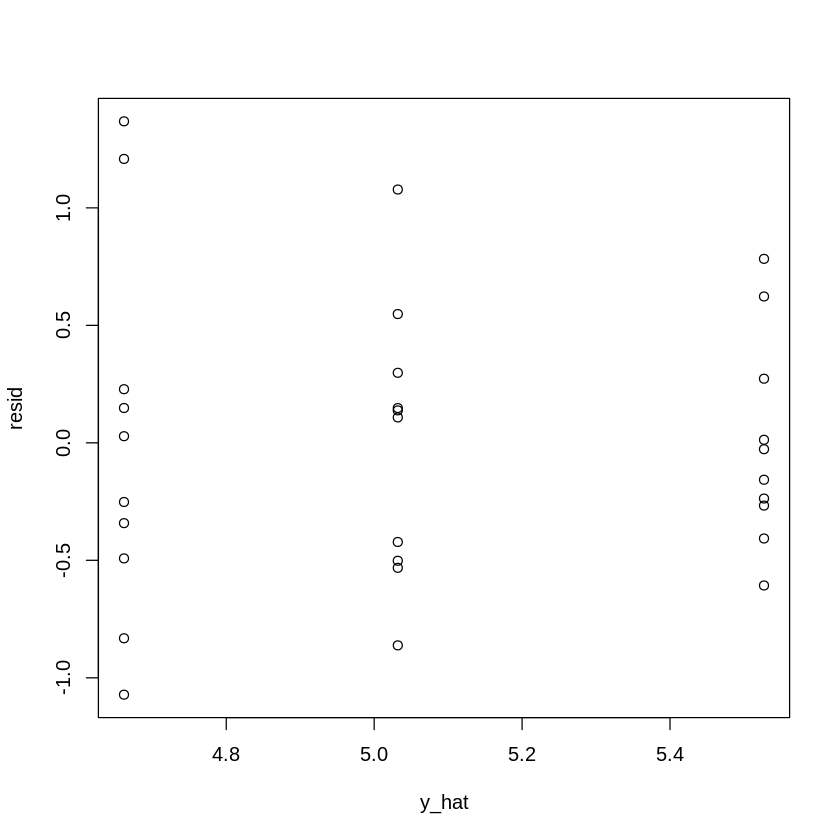

In [75]:
plot(y_hat, resid)